### TensorFlow Train SOC

In [1]:
# -*- coding: utf-8 -*-
# """
# tf_train_SOC.ipynb
# Created on Dec 31, 2024
# @ Author: Mazhar
# """

#### Import necessary libraries

In [2]:
import joblib
from pathlib import Path
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import mlflow
import mlflow.sklearn
import mlflow.keras
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2

# Import Utility Functions
from model_utils import classify_skewness, transform_features_for_skewness, transform_targets
from model_utils import range_without_outliers, remove_outliers
from model_utils import SkewnessTransformer
from model_utils import categorical_value_counts_to_df, group_low_frequency_categories
from model_utils import plot_geographical_features
from model_utils import get_overfitting_status
import random

import warnings
warnings.filterwarnings("ignore")

#### Columns To Drop

In [3]:
# COLS_TO_DROP = ["longitude", "latitude"]
COLS_TO_DROP = ["longitude", "latitude", "Soil group", "Land class", "Soil type"]

#### Hyperparameters and Other definitions

In [4]:
# L1_FACTOR: float = 0.001
L1_FACTOR: float = 0.01
L2_FACTOR: float = 0.01
UPDATE_RATE: float = 0.001
MAX_L1_FACTOR: float = 0.02
PATIENCE: int = 10
PATIENCE_FOR_L1: int = 3
RESTORE_BEST_WEIGHTS: bool = True
EPOCHS: int = 100
BATCH_SIZE: int = 32

POWER_TRANSFORMER_METHOD: str = "yeo-johnson"
TRAIN_SIZE: float = 0.7
TEST_SIZE: float = 0.2
VAL_SIZE: float = 0.1

SELECTED_TARGET = "SOC"

DATASET_VERSION: str = "v3"
MODEL_SAVE_PATH: str = f"./checkpoints/tf_{SELECTED_TARGET}_model/"

# Make dir if it doesn't exist
Path(MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True)
# Path(BEST_MODEL_SUMMARY_CSV_PATH).mkdir(parents=True, exist_ok=True)

In [5]:
# Set random seed for reproducibility
# seeds: list[int] = [42, 101, 2023, 7, 99]
RANDOM_STATE: int = 7

In [6]:
APPLY_DYNAMIC_LI_REG: bool = True

In [7]:
print(f"Dynamic L1: {APPLY_DYNAMIC_LI_REG}")
print(f"Seed: {RANDOM_STATE}")

Dynamic L1: True
Seed: 7


In [8]:
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

#### Load Dataset

In [9]:
file_path = f"../../../data/merged_{DATASET_VERSION}.csv"
# Create a Path object
data_file_path = Path(file_path)
data = pd.read_csv(data_file_path)

df = data.copy()

In [10]:
df_isda = df.iloc[477:]
df_ipage = df.iloc[:477]

In [11]:
# print(f"Dataset: {df.head()}")
df.head()

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


In [12]:
length_df = len(df)
print(f"Length of Dataset: {length_df}")

Length of Dataset: 2584


In [13]:
df.describe()

,longitude,latitude,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,22.979895,12.711743,5.869107,1.002453,0.070375,0.238226,8.586086,8.843246,0.113593,1.187543,56.202786,22.819659,20.175310
std,31.597277,6.212016,0.518722,0.626685,0.039282,0.140441,9.266400,5.267589,0.132118,0.470586,10.998711,7.472131,5.535707
min,4.430300,8.039070,4.100000,0.100000,0.000800,0.000000,0.060000,0.650000,0.001611,0.080000,20.000000,10.000000,10.000000
25%,6.972760,9.251048,5.536365,0.553925,0.040000,0.138462,3.664697,5.668802,0.024444,0.879671,51.000000,18.000000,16.000000
50%,8.617840,9.971485,5.913315,0.807029,0.062176,0.209134,5.714590,7.243420,0.060213,1.143550,58.000000,20.000000,20.000000
75%,10.430405,11.159215,6.226348,1.290080,0.092213,0.313721,9.579792,10.298875,0.154269,1.443010,64.000000,24.000000,22.000000
max,89.416700,25.850000,7.945400,4.480000,0.257264,0.990000,74.500000,39.700000,0.990000,4.000000,80.000000,40.000000,60.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longitude   2584 non-null   float64
 1   latitude    2584 non-null   float64
 2   Area        2584 non-null   object 
 3   Soil group  2584 non-null   object 
 4   Land class  2584 non-null   object 
 5   Soil type   2584 non-null   object 
 6   pH          2584 non-null   float64
 7   SOC         2584 non-null   float64
 8   Nitrogen    2584 non-null   float64
 9   Potassium   2584 non-null   float64
 10  Phosphorus  2584 non-null   float64
 11  Sulfur      2584 non-null   float64
 12  Boron       2584 non-null   float64
 13  Zinc        2584 non-null   float64
 14  Sand        2584 non-null   float64
 15  Silt        2584 non-null   float64
 16  Clay        2584 non-null   float64
dtypes: float64(13), object(4)
memory usage: 343.3+ KB


In [15]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())
print("\n")
print(df.isnull().sum())

False
0


longitude     0
latitude      0
Area          0
Soil group    0
Land class    0
Soil type     0
pH            0
SOC           0
Nitrogen      0
Potassium     0
Phosphorus    0
Sulfur        0
Boron         0
Zinc          0
Sand          0
Silt          0
Clay          0
dtype: int64


In [16]:
# Check for duplicates
duplicates = df.duplicated()
print(duplicates.sum())

0


#### Drop Columns 

In [17]:
df.drop(COLS_TO_DROP, axis=1, inplace=True)
df.describe()

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,5.869107,1.002453,0.070375,0.238226,8.586086,8.843246,0.113593,1.187543,56.202786,22.819659,20.175310
std,0.518722,0.626685,0.039282,0.140441,9.266400,5.267589,0.132118,0.470586,10.998711,7.472131,5.535707
min,4.100000,0.100000,0.000800,0.000000,0.060000,0.650000,0.001611,0.080000,20.000000,10.000000,10.000000
25%,5.536365,0.553925,0.040000,0.138462,3.664697,5.668802,0.024444,0.879671,51.000000,18.000000,16.000000
50%,5.913315,0.807029,0.062176,0.209134,5.714590,7.243420,0.060213,1.143550,58.000000,20.000000,20.000000
75%,6.226348,1.290080,0.092213,0.313721,9.579792,10.298875,0.154269,1.443010,64.000000,24.000000,22.000000
max,7.945400,4.480000,0.257264,0.990000,74.500000,39.700000,0.990000,4.000000,80.000000,40.000000,60.000000


#### Drop raw longitude and latitude if present

In [18]:
# if 'longitude' in features and 'latitude' in features:
#     features.remove(COLS_TO_DROP[0])
#     features.remove(COLS_TO_DROP[1])

#### Define target variable and features

In [19]:
targets = ["Boron", "Zinc", "SOC"]
features = [col for col in df.columns if col not in targets]

In [20]:
print(f"Targe: {targets}")
print(f"Features: {features}")

Targe: ['Boron', 'Zinc', 'SOC']
Features: ['Area', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


#### Identify categorical and numerical features

In [21]:
categorical_features = df[features].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df[features].select_dtypes(include=['number']).columns.tolist()

In [22]:
print(f"Categorical Features:\n {categorical_features}\n")
print(f"Numerical Features:\n {numerical_features}\n")

Categorical Features:
 ['Area']

Numerical Features:
 ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']



#### Targets

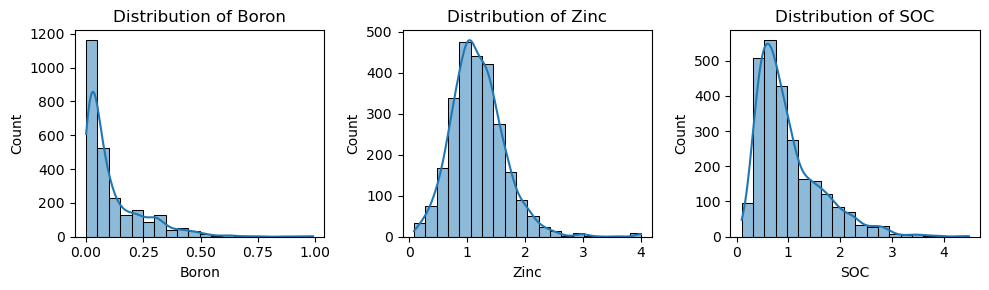

In [23]:
# Set up the number of rows and columns
num_targets = len(targets)
cols = 3  # Number of columns per row
rows = (num_targets + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 3))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through numerical features and plot
for i, target in enumerate(targets):
    sns.histplot(df[target], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {target}")

# Remove unused subplots
for i in range(len(targets), len(axes)):
    fig.delaxes(axes[i])

# Adjust Layout
plt.tight_layout()
plt.show()

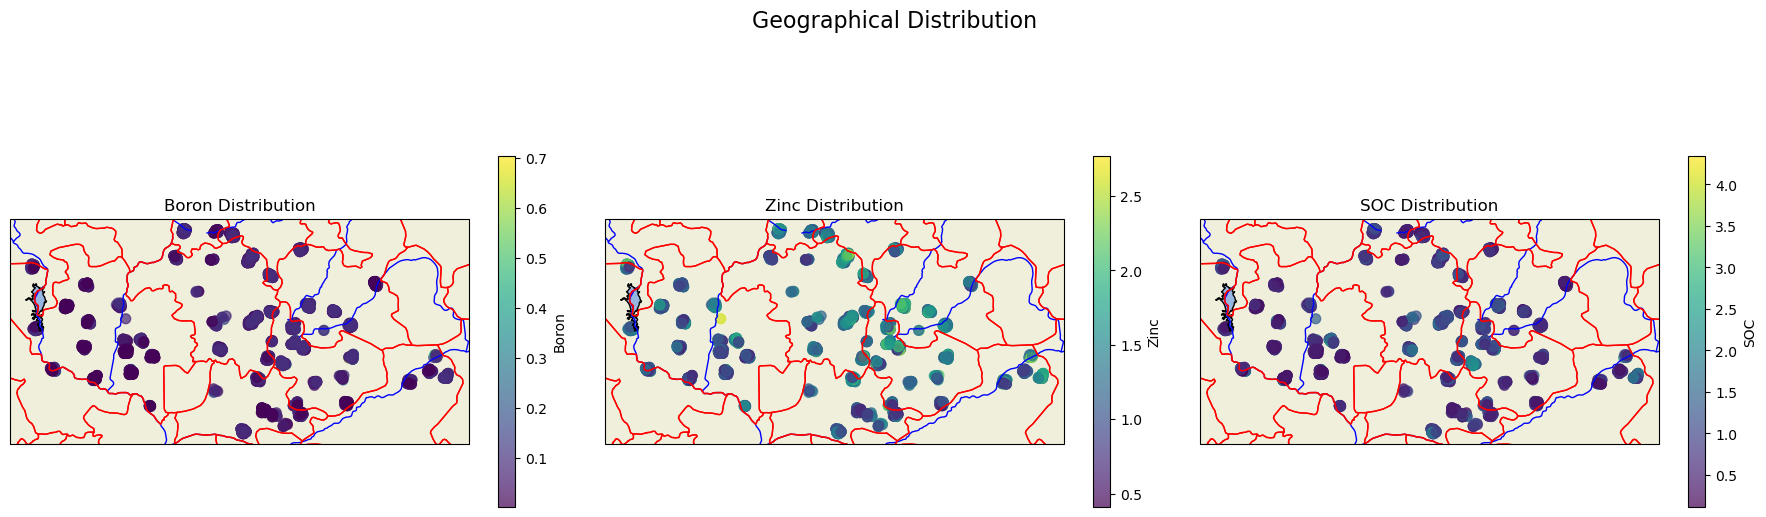

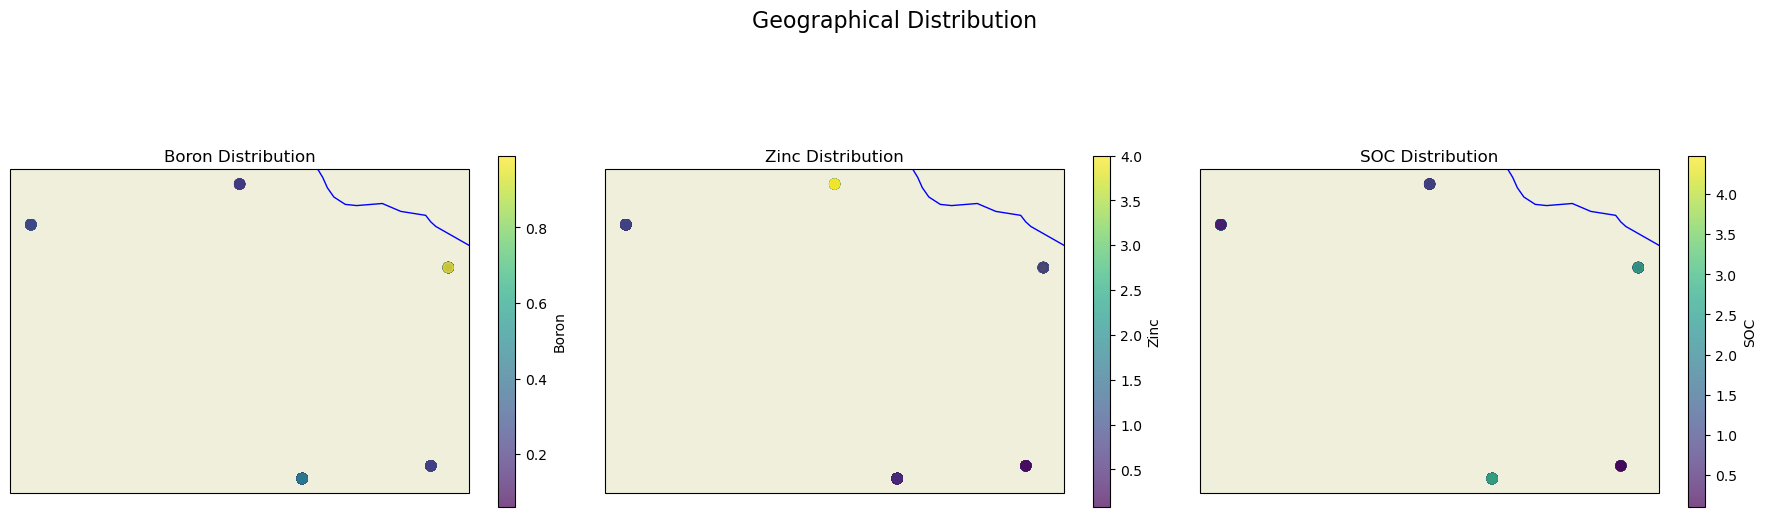

In [24]:
plot_geographical_features(df_isda, targets, lat_col='latitude', lon_col='longitude')
plot_geographical_features(df_ipage, targets, lat_col='latitude', lon_col='longitude')

#### 1. Analyze Ccategorical_features

In [25]:
print(f"Unique Values in 'Area' col:\n {df['Area'].unique()}\n")
print("*" * 120)
# print(f"Unique Values in 'Soil group' col:\n {df['Soil group'].unique()}\n")
# print("*" * 120)
# print(f"Unique Values in 'Land class' col\n: {df['Land class'].unique()}\n")
# print("*" * 120)
# print(f"Unique Values in 'Soil type' col\n: {df['Soil type'].unique()}\n")

Unique Values in 'Area' col:
 ['Mithpukur' 'Pirgacha ' 'Gangachara' 'Kaunia upazila' 'Taraganj Thana'
 'Bauchi' 'Taraba' 'Plateau' 'Kaduna' 'Nasarawa' 'Niger' 'Kebbi' 'Kano'
 'Kwara' 'Katsina' 'Adamawa']

************************************************************************************************************************


In [26]:
# Get the value counts in Categorical Columns of DataFrame
counts_df = categorical_value_counts_to_df(df)
# Print the resulting DataFrame
print(f"Categorical Value Counts")
print("*" * 24, "\n")
# print(counts_df)
counts_df

Categorical Value Counts
************************ 



,Categorical Feature,Sub-Category,Each Count,Total Unique Count
0,Area,Niger,561,16
1,Area,Kaduna,402,16
2,Area,Plateau,359,16
3,Area,Bauchi,226,16
4,Area,Nasarawa,215,16
5,Area,Mithpukur,186,16
6,Area,Taraba,135,16
7,Area,Pirgacha,125,16
8,Area,Katsina,81,16
9,Area,Taraganj Thana,79,16


In [27]:
# Group low frequency categories
df = group_low_frequency_categories(df, threshold=5)
# Print the resulting DataFrame
# print(f"Grouped Low Frequency Categories")
# print("*" * 32, "\n")
# print(modified_df)
# modified_df.head(3)

# # Check Again | Get the value counts DataFrame
# counts_df = categorical_value_counts_to_df(df)
# # Print the resulting DataFrame
# print(f"Categorical Value Counts")
# print("*" * 24, "\n")
# # print(counts_df)
# counts_df

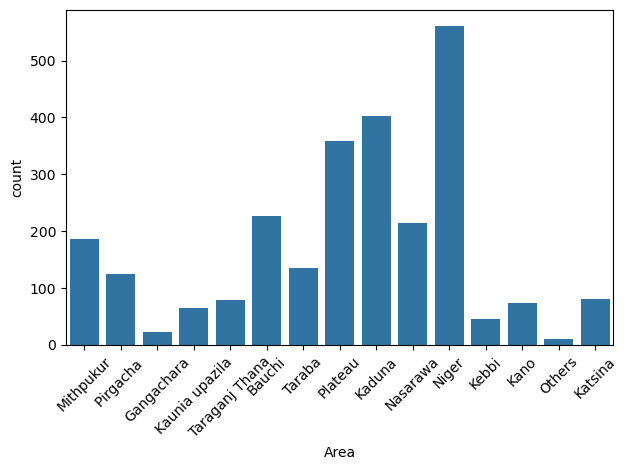

In [28]:
sns.countplot(data=df, x="Area")
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [29]:
# # Set up the figure and axes
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows and 2 columns

# # Flatten the axes for easy indexing
# axes = axes.flatten()

# # Loop through the categorical features and plot
# for i, feature in enumerate(categorical_features):
#     sns.countplot(data=df, x=feature, ax=axes[i])
#     axes[i].set_title(f"Distribution of {feature}")
#     axes[i].tick_params(axis='x', rotation=45)

# # Adjust layout
# plt.tight_layout()
# plt.show()

#### 2. Analyze Numerical Features

##### 1. Histograms: To visualize the distributions of numerical variables:

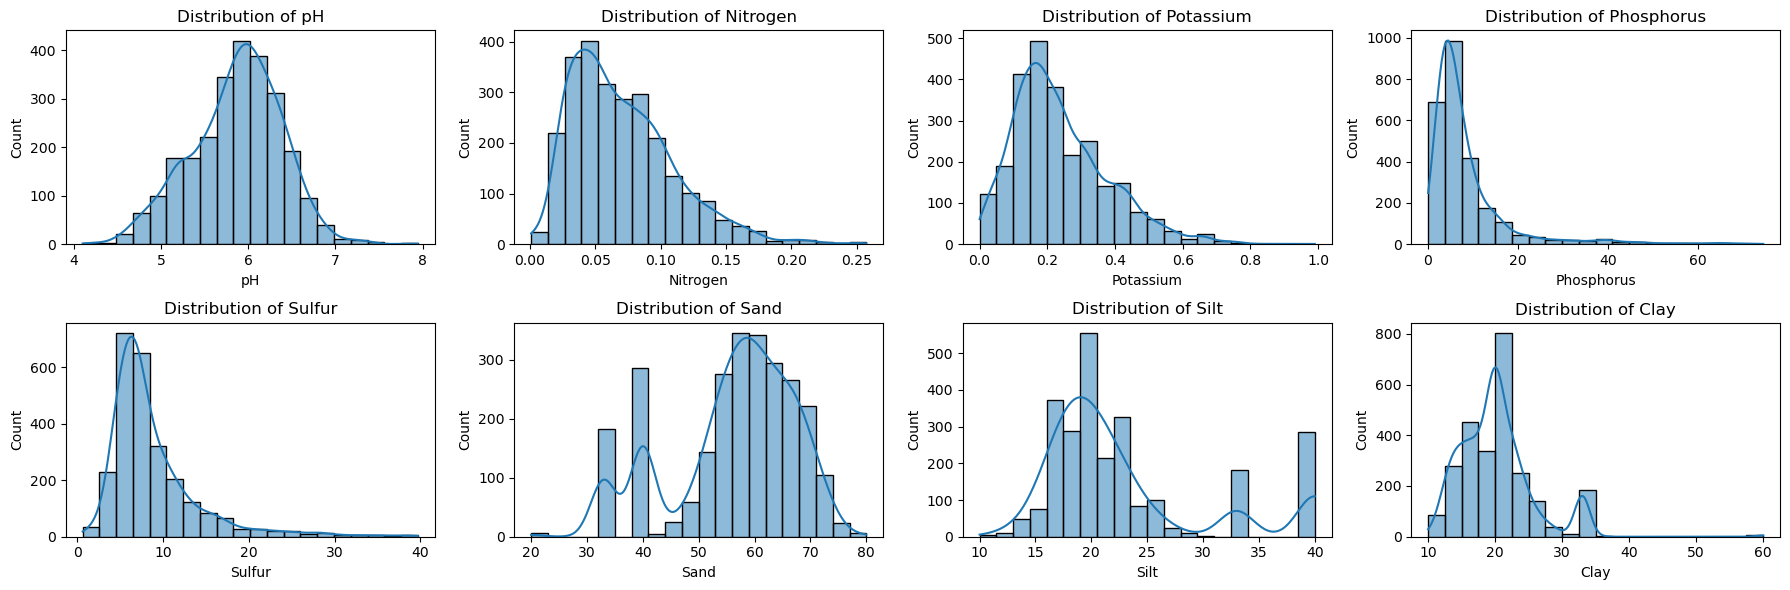

In [30]:
# Set up the number of rows and columns
num_features = len(numerical_features)
cols = 4  # Number of columns per row
rows = (num_features + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 6))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through numerical features and plot
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

# Remove unused subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust Layout
plt.tight_layout()
plt.show()

##### 2. Check for Outliers

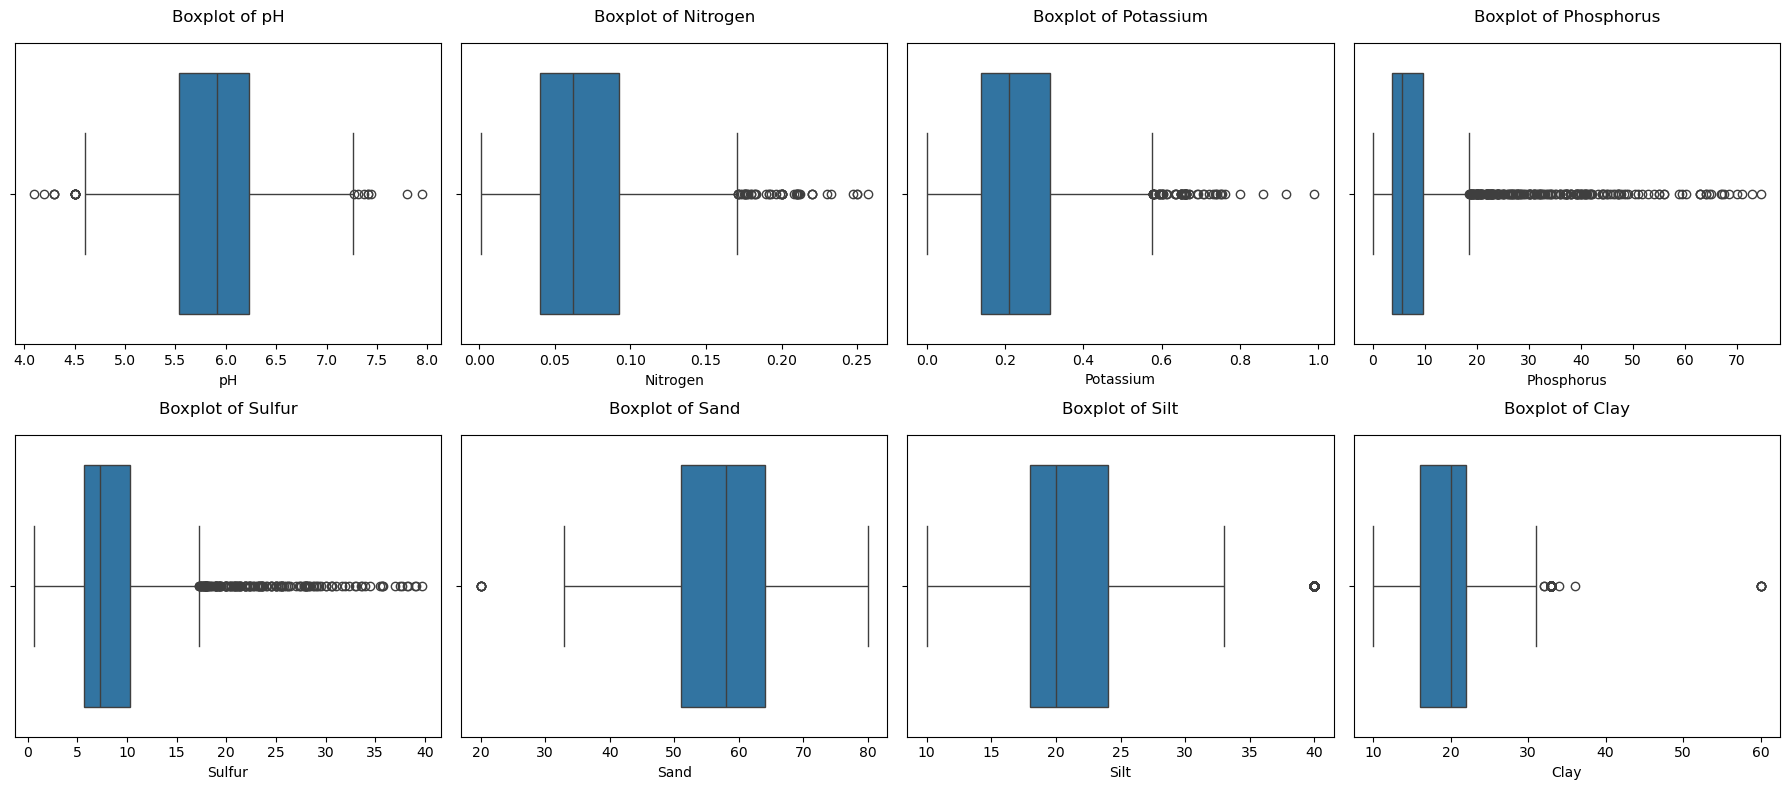

In [31]:
# Set the number of columns per row
cols = 4  # 4 plots in each row
num_features = len(numerical_features)
rows = (num_features + cols - 1) // cols  # Calculate the required number of rows dynamically

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))  # Adjust height for rows

# Flatten the axes for easier iteration
axes = axes.flatten()

# Loop through the numerical features and plot boxplots
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature}", pad=15)  # Add padding for the title

# Remove unused subplots (if any)
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

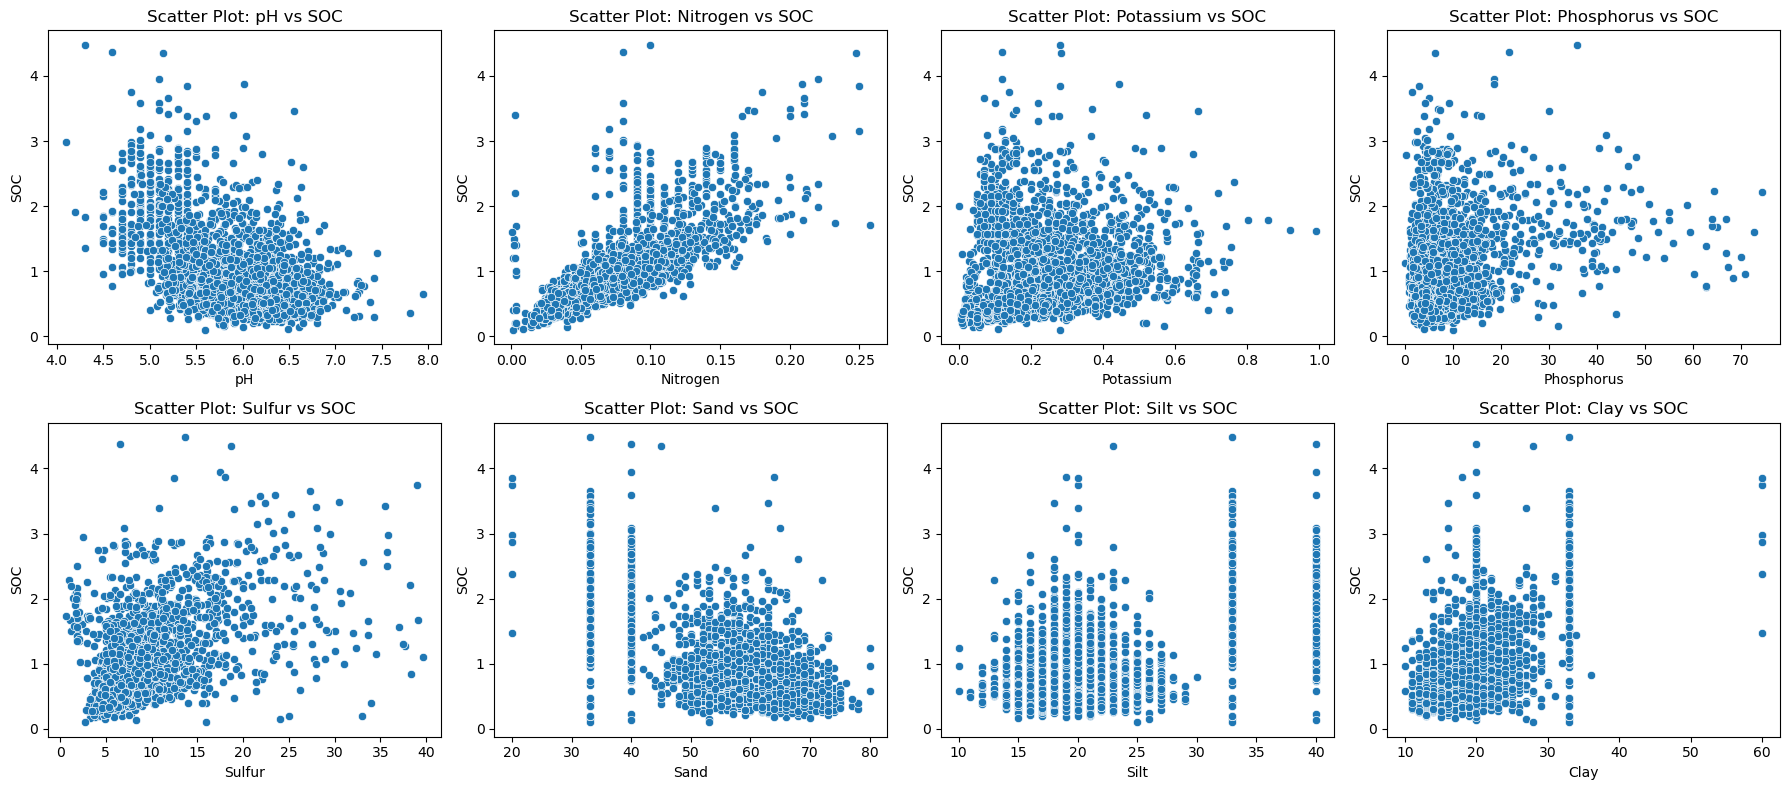

In [32]:
# Number of features
num_features = len(numerical_features)

# Determine the layout: 3 subplots per row
cols = 4
rows = (num_features + cols - 1) // cols  # Calculate rows needed

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows), constrained_layout=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop through numerical features and plot
for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=feature, y=SELECTED_TARGET, data=df, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {feature} vs {SELECTED_TARGET}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(SELECTED_TARGET)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Show the plots
plt.tight_layout()
plt.show()

##### 3. Display Range of Values in Numerical Features without Outliers

In [33]:
#df.drop(["longitude", "latitude"], axis=1).describe()

In [34]:
# Display the range for each numerical feature
print(f"\nRange of Values in Each Column (Numerical) without Outliers")
print("*" * 59, "\n")
for feature in numerical_features:
    min_val, max_val = range_without_outliers(df, feature)
    print(f"{feature}: Min: {min_val}, Max: {max_val}\n")


Range of Values in Each Column (Numerical) without Outliers
*********************************************************** 

pH: Min: 4.6, Max: 7.25826

Nitrogen: Min: 0.0008, Max: 0.170421

Potassium: Min: 0.0, Max: 0.5761871794871795

Phosphorus: Min: 0.06, Max: 18.4091

Sulfur: Min: 0.65, Max: 17.236

Sand: Min: 33.0, Max: 80.0

Silt: Min: 10.0, Max: 33.0

Clay: Min: 10.0, Max: 31.0



##### 4. Remove Outliers

In [35]:
# Dynamically apply the function to each numerical feature
for feature in numerical_features:
    df = remove_outliers(df, feature)

length_df_remove_outliers = len(df)
print(f"Length of Dataset After Removal of Ouliers")
print("*"* 42)
print(length_df_remove_outliers)

# Print the cleaned dataset
print("\nDataset after removing outliers:")
print("*"* 32, "\n")
df.describe().T

Length of Dataset After Removal of Ouliers
******************************************
2572

Dataset after removing outliers:
******************************** 



,count,mean,std,min,25%,50%,75%,max
pH,2572.0,5.872734,0.516360,4.100000,5.544477,5.918895,6.227370,7.945400
SOC,2572.0,0.999961,0.626380,0.100000,0.552021,0.803703,1.284992,4.480000
Nitrogen,2572.0,0.070295,0.039317,0.000800,0.040000,0.062087,0.092144,0.257264
Potassium,2572.0,0.238257,0.140553,0.000000,0.137771,0.209207,0.313721,0.990000
Phosphorus,2572.0,8.309131,8.348160,0.060000,3.657857,5.703735,9.403460,62.900000
Sulfur,2572.0,8.804159,5.227483,0.650000,5.660660,7.236340,10.217925,39.700000
Boron,2572.0,0.112374,0.130301,0.001611,0.024301,0.059704,0.153684,0.990000
Zinc,2572.0,1.189048,0.470255,0.080000,0.880000,1.145280,1.443835,4.000000
Sand,2572.0,56.286547,10.953631,20.000000,52.000000,58.000000,64.000000,80.000000
Silt,2572.0,22.747667,7.411745,10.000000,18.000000,20.000000,24.000000,40.000000


##### 5. Correlation

In [36]:
df_corr = df[numerical_features + targets].corr()
df_corr

,pH,Nitrogen,Potassium,Phosphorus,Sulfur,Sand,Silt,Clay,Boron,Zinc,SOC
pH,1.000000,-0.353364,0.183546,-0.256730,-0.345696,0.599933,-0.577791,-0.406079,-0.389050,0.235345,-0.511356
Nitrogen,-0.353364,1.000000,0.284249,0.163948,0.456085,-0.407256,0.273152,0.344600,0.481068,0.101858,0.787075
Potassium,0.183546,0.284249,1.000000,0.064518,0.195483,0.016784,-0.178641,0.106429,0.105693,0.487248,0.127994
Phosphorus,-0.256730,0.163948,0.064518,1.000000,0.190269,-0.414837,0.480646,0.182917,0.477100,-0.051523,0.316231
Sulfur,-0.345696,0.456085,0.195483,0.190269,1.000000,-0.471684,0.347860,0.423161,0.492216,0.060826,0.526951
Sand,0.599933,-0.407256,0.016784,-0.414837,-0.471684,1.000000,-0.826530,-0.771692,-0.660575,0.149762,-0.626155
Silt,-0.577791,0.273152,-0.178641,0.480646,0.347860,-0.826530,1.000000,0.373927,0.656392,-0.278376,0.571937
Clay,-0.406079,0.344600,0.106429,0.182917,0.423161,-0.771692,0.373927,1.000000,0.413467,0.003741,0.426737
Boron,-0.389050,0.481068,0.105693,0.477100,0.492216,-0.660575,0.656392,0.413467,1.000000,-0.136705,0.634796
Zinc,0.235345,0.101858,0.487248,-0.051523,0.060826,0.149762,-0.278376,0.003741,-0.136705,1.000000,0.016218


In [37]:
# df_corr.iloc[:, :-2]

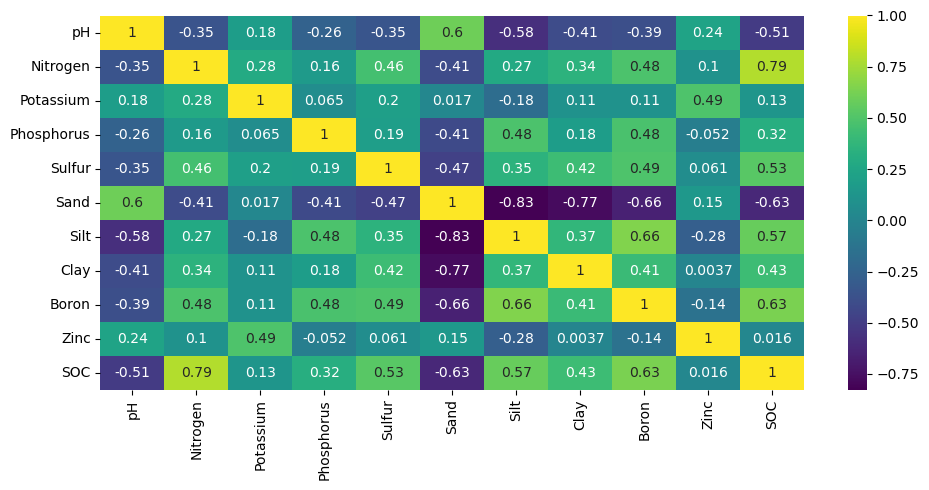

In [38]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_corr, annot=True, cmap='viridis')
# plt.ylim(10, 0)
plt.tight_layout()
plt.show()

1. Boron:
    - Strong Positive Relationships:
        - Sulfur (0.492): Boron shows a strong positive correlation with Sulfur, indicating that an increase in Sulfur is often associated with an increase in Boron.
        - Silt (0.656): There is a significant positive correlation with Silt, suggesting that soils with higher Silt content tend to have higher Boron levels.
        - SOC (0.635): Boron has a strong positive relationship with SOC (Soil Organic Carbon), implying that organic carbon-rich soils are likely to have higher Boron levels.
    - Moderate Positive Relationships:
        - Phosphorus (0.477): A moderately strong correlation, indicating some dependence between Boron and Phosphorus.
        - Clay (0.413): Boron has a moderate positive relationship with Clay.
    - Strong Negative Relationships:
        - Sand (-0.661): Boron is strongly negatively correlated with Sand, meaning that sandy soils generally have lower Boron levels.
2. Zinc:
    - Moderate Positive Relationships:
        - Potassium (0.487): Zinc has a moderate positive correlation with Potassium, indicating some association between the two.
    - Weak or Negligible Relationships:
        - Zinc does not exhibit strong relationships with most other variables. Its correlation with SOC (0.016) and others (e.g., Boron) suggests minimal dependency.
3. SOC (Soil Organic Carbon):
    - Strong Positive Relationships:
        - Nitrogen (0.787): SOC is strongly positively correlated with Nitrogen, indicating that higher organic carbon levels are often accompanied by increased Nitrogen.
        - Silt (0.572): There is a strong positive correlation with Silt, suggesting that SOC tends to be higher in soils with more Silt content.
        - Boron (0.635): SOC has a strong positive relationship with Boron, linking organic matter to Boron availability.
    - Moderate Positive Relationships:
        - Sulfur (0.527): SOC has a moderate positive relationship with Sulfur, showing some dependency.
        - Clay (0.427): SOC has a moderate positive relationship with Clay content.
        - Phosphorus (0.316): SOC has a moderate positive correlation with Phosphorus.
    - Strong Negative Relationships:
        - Sand (-0.626): SOC is strongly negatively correlated with Sand, meaning that sandy soils typically have lower organic carbon.
     
Summary:

- Boron:
    - Strong ties: SOC, Silt, Sulfur.
    - Negative tie: Sand.
- Zinc:
    - Stronger tie: Potassium.
    - Weak/Minimal ties: SOC and others.
- SOC:
    - Strong ties: Nitrogen, Silt, Boron.
    - Moderate ties: Sulfur, Clay, Phosphorus.
    - Negative tie: Sand.
      
##### These relationships suggest that SOC and Boron are heavily influenced by soil texture (e.g., Silt, Sand, and Clay), while Zinc is less strongly related to most variables.

Since `Zinc` has a strong relationship only with Potassium, then Potassium will play a significant role in predicting Zinc, as it contributes the most meaningful information about Zinc's variation. The rest of the features, having minimal or no correlation with Zinc, will provide little to no additional predictive power and might even introduce noise into the model.

- Key Points:
    1. Strong Correlation: A strong correlation indicates that the variable (Potassium) captures a substantial portion of the variability in Zinc.
Minimal Relationships: Variables with weak or negligible correlations with Zinc contribute little value in predicting Zinc and may be excluded for model simplicity.
    2. Implication in Machine Learning:
        - During feature selection, only Potassium might be retained for predicting Zinc.
        - Adding unrelated features could lead to overfitting or dilute the predictive power of the model.

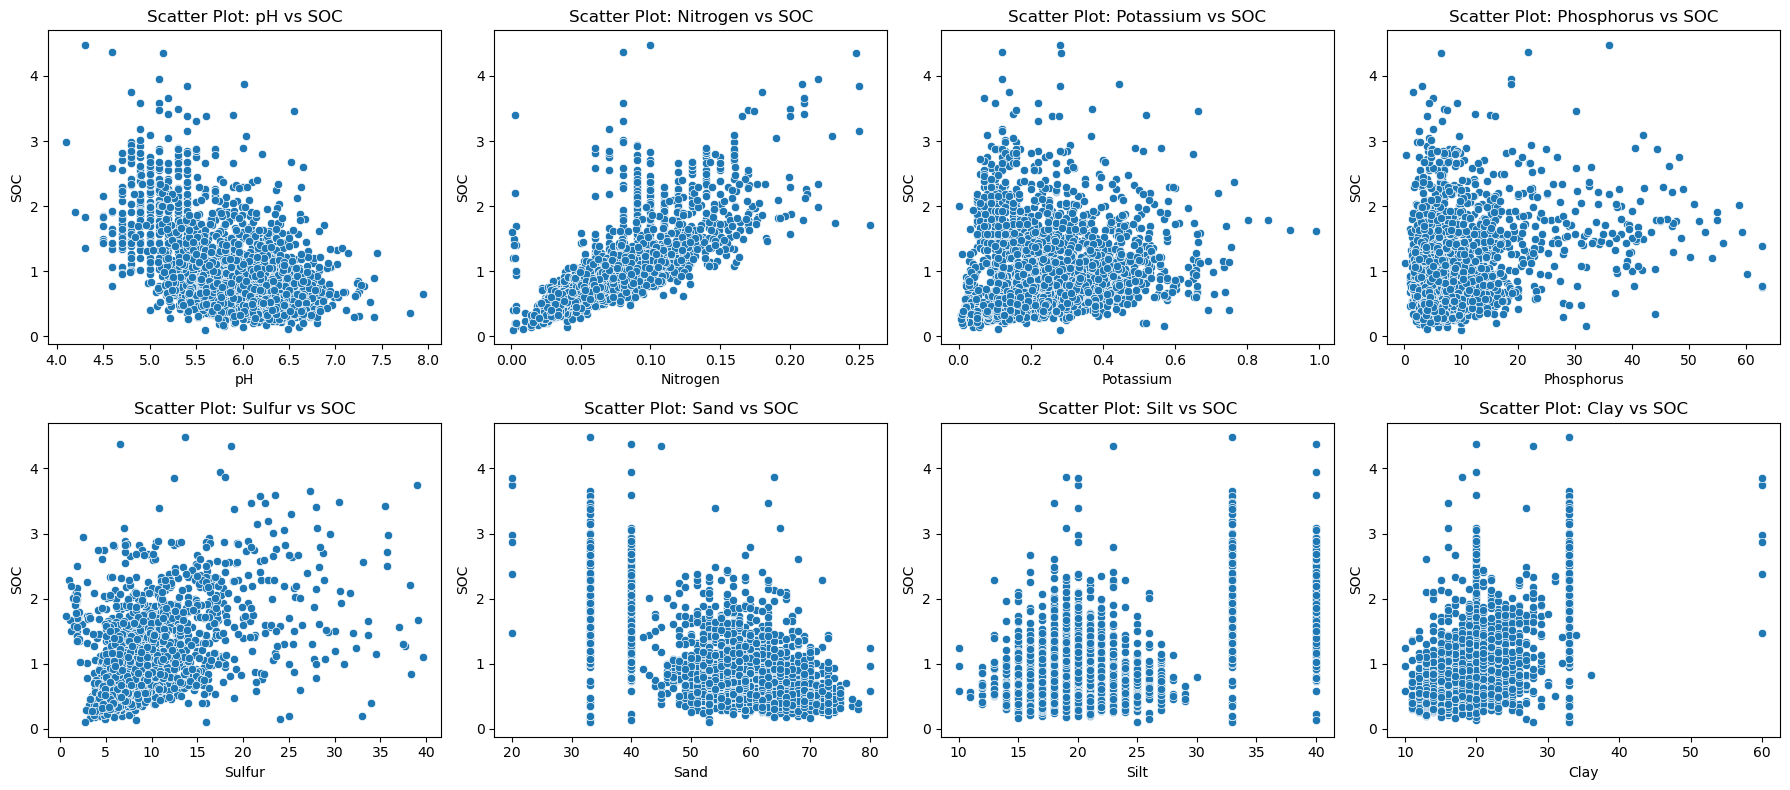

In [39]:
# Number of features
num_features = len(numerical_features)

# Determine the layout: 3 subplots per row
cols = 4
rows = (num_features + cols - 1) // cols  # Calculate rows needed

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows), constrained_layout=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop through numerical features and plot
for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=feature, y=SELECTED_TARGET, data=df, ax=axes[i])
    axes[i].set_title(f'Scatter Plot: {feature} vs {SELECTED_TARGET}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(SELECTED_TARGET)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Show the plots
plt.tight_layout()
plt.show()

#### Dataset split

In [40]:
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['Area']
Numerical Features: ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


In [41]:
# Coluumns to Drop for Dummies
COLS_TO_DROP_DUMMIES = ["Area"]

In [42]:
area_dummies = pd.get_dummies(df[COLS_TO_DROP_DUMMIES[0]], drop_first=True)
df = pd.concat([df.drop(COLS_TO_DROP_DUMMIES[0], axis=1), area_dummies], axis=1)
df.columns

Index(['pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Boron',
       'Zinc', 'Sand', 'Silt', 'Clay', 'Gangachara', 'Kaduna', 'Kano',
       'Katsina', 'Kaunia upazila', 'Kebbi', 'Mithpukur', 'Nasarawa', 'Niger',
       'Others', 'Pirgacha ', 'Plateau', 'Taraba', 'Taraganj Thana'],
      dtype='object')

In [43]:
df.head(3)

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,...,Kaunia upazila,Kebbi,Mithpukur,Nasarawa,Niger,Others,Pirgacha,Plateau,Taraba,Taraganj Thana
0,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
1,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
2,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False


In [44]:
# Update Features, Cacategorical_features, Numerical Features
features = [col for col in df.columns if col not in targets]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
boolean_features = df.select_dtypes(include=['boolean']).columns.tolist()

print(f"Updated Features: {features}")
print(f"Updated Numerical Features: {numerical_features}")
print(f"Updated Categorical Features: {categorical_features}")
print(f"Updated Bolean_features Features: {boolean_features}")

Updated Features: ['pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay', 'Gangachara', 'Kaduna', 'Kano', 'Katsina', 'Kaunia upazila', 'Kebbi', 'Mithpukur', 'Nasarawa', 'Niger', 'Others', 'Pirgacha ', 'Plateau', 'Taraba', 'Taraganj Thana']
Updated Numerical Features: ['pH', 'SOC', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Boron', 'Zinc', 'Sand', 'Silt', 'Clay']
Updated Categorical Features: []
Updated Bolean_features Features: ['Gangachara', 'Kaduna', 'Kano', 'Katsina', 'Kaunia upazila', 'Kebbi', 'Mithpukur', 'Nasarawa', 'Niger', 'Others', 'Pirgacha ', 'Plateau', 'Taraba', 'Taraganj Thana']


In [45]:
# X = df[numerical_features + categorical_features]  # Full feature set
X = df[numerical_features + categorical_features + boolean_features]
y = pd.DataFrame(df[targets][SELECTED_TARGET])  # Target variables

# Convert y DataFrame to a 1D NumPy array
y = y.values.ravel()  # Shape changes from e.g (2572, 1) to (2572,)

In [46]:
X.head(3)

,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,...,Kaunia upazila,Kebbi,Mithpukur,Nasarawa,Niger,Others,Pirgacha,Plateau,Taraba,Taraganj Thana
0,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
1,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False
2,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,...,False,False,True,False,False,False,False,False,False,False


In [47]:
# y.head(3)

In [48]:
# print(f"X Columns: {X.columns.tolist()}")
# print(f"y Columns: {y.columns}")
# print(type(y))

In [49]:
print(f"X Shape: {X.shape}")
print(f"X Type: {type(X)}")

print(f"y Shape: {y.shape}")
print(f"y Type: {type(y)}")

X Shape: (2572, 25)
X Type: <class 'pandas.core.frame.DataFrame'>
y Shape: (2572,)
y Type: <class 'numpy.ndarray'>


#### Apply Transformations To SELECTED_TARGET 

In [50]:
# specific_transformations = {"Boron": "boxcox"}
# transformed_targets, target_transformation_report = transform_targets(y, skewness_threshold=0.75, specific_transformations=None)

In [51]:
# target_transformation_report

In [52]:
# transformed_targets.head(3)

In [53]:
# # Update Targets
# y = transformed_targets
# y.head(3)

#### Split data into train, Val and test sets

In [54]:
# First split: Train + Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=(1 - TRAIN_SIZE), 
    random_state=RANDOM_STATE,
    # stratify=y
)

# Second split: Validation + Test from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), 
    random_state=RANDOM_STATE,
    # stratify=y_temp
)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (1800, 25), Validation Set: (257, 25), Test Set: (515, 25)


#### Apply Scaling

In [55]:
# Step 2: Scale the data using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Define Models

In [56]:
# Define a custom L1 regularizer that supports both static and dynamic L1
class FlexibleL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, l1_factor, is_dynamic=False):
        """
        Flexible L1 Regularizer that supports both dynamic and static L1 factors.
        
        Args:
        - l1_factor (float or tf.Variable): L1 regularization factor.
        - is_dynamic (bool): Whether to apply dynamic regularization using a tf.Variable.
        """
        self.l1_factor = tf.Variable(l1_factor, trainable=False, dtype=tf.float32) if is_dynamic else l1_factor
        self.is_dynamic = is_dynamic

    def __call__(self, x):
        if self.is_dynamic:
            return tf.reduce_sum(self.l1_factor * tf.abs(x))
        return tf.reduce_sum(self.l1_factor * tf.abs(x))

    def get_config(self):
        return {"l1_factor": self.l1_factor.numpy() if self.is_dynamic else self.l1_factor}


# Custom callback for dynamic L1 adjustment
class FlexibleL1RegularizationCallback(Callback):
    def __init__(self, l1_factor, is_dynamic=False, update_rate=0.005, monitor='val_loss', patience=5, max_l1_factor=0.02):
        """
        Callback to dynamically adjust L1 regularization factor during training.
        
        Args:
        - l1_factor (tf.Variable): The L1 factor to adjust.
        - is_dynamic (bool): Whether to enable dynamic adjustment.
        - update_rate (float): Increment rate for the L1 factor.
        - monitor (str): Metric to monitor for dynamic adjustment.
        - patience (int): Number of epochs to wait for improvement before updating L1.
        - max_l1_factor (float): Maximum allowed value for the L1 factor.
        """
        super().__init__()
        self.l1_factor = l1_factor
        self.is_dynamic = is_dynamic
        self.update_rate = update_rate
        self.monitor = monitor
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0
        self.max_l1_factor = max_l1_factor

    def on_epoch_end(self, epoch, logs=None):
        if not self.is_dynamic:
            return  # Skip adjustment for static L1

        current_val_loss = logs.get(self.monitor)
        if current_val_loss is not None:
            if current_val_loss < self.best_val_loss:
                self.best_val_loss = current_val_loss
                self.wait = 0
            else:
                self.wait += 1

        if self.wait >= self.patience:
            # Increase L1 factor but cap it at max_l1_factor
            new_l1_factor = min(self.l1_factor.numpy() + self.update_rate, self.max_l1_factor)
            self.l1_factor.assign(new_l1_factor)

            print(f"Epoch {epoch + 1}: Increased L1 factor to {self.l1_factor.numpy():.4f}")
            self.wait = 0


# Create the model with a flag to switch between dynamic and static L1 regularization
def model_dynamicL1(input_dim, l1_factor, is_dynamic=False):
    """
    Create a model with flexible L1 regularization.
    
    Args:
    - input_dim (int): Number of input features.
    - l1_factor (float or tf.Variable): Initial L1 factor.
    - is_dynamic (bool): Whether to enable dynamic regularization.
    
    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    regularizer = FlexibleL1Regularizer(l1_factor, is_dynamic)
    # regularizer2 = l1_l2(l1=0.02, l2=0.01))

    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=regularizer),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizer),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizer),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model


def model_L1_L2(input_dim, l1_factor, l2_factor):
    """
    Create a model with flexible L1 and L2 regularization.
    
    Args:
    - input_dim (int): Number of input features.
    - l1_factor (float or tf.Variable): Initial L1 factor.
    - l2_factor (float or tf.Variable): Initial L2 factor.
    
    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    regularizer_L1_L2 = l1_l2(l1=l1_factor, l2=l2_factor)

    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=regularizer_L1_L2),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizer_L1_L2),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizer_L1_L2),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Input Dimensions
input_dim = X_train_scaled.shape[1]

# Define dynamic L1 factor
dynamic_l1_factor = tf.Variable(L1_FACTOR, trainable=False, dtype=tf.float32)

if APPLY_DYNAMIC_LI_REG:
    # Create Model | with Dynamic L1 Regularization CallBack
    model = model_dynamicL1(input_dim, l1_factor=dynamic_l1_factor, is_dynamic=True)
else:
    # Create Model | with Static L1 and L2 Factors
    model = model_L1_L2(input_dim=10, l1_factor=L1_FACTOR, l2_factor=L2_FACTOR)

#### Train Model

In [57]:
# DAGSHUB
import dagshub
# dagshub.init(repo_owner='mm-mazhar', repo_name='IPAGE', mlflow=True)
dagshub.init(repo_owner="Omdena", repo_name="IPage", mlflow=True)

Accessing as mm-mazhar

Initialized MLflow to track repo "Omdena/IPage"

Repository Omdena/IPage initialized!

Training with Dynamic L1
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 12.3401 - mae: 0.6819 - mse: 0.7995 - rmse: 0.8812 - val_loss: 7.7208 - val_mae: 0.3054 - val_mse: 0.1861 - val_rmse: 0.4314
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6221 - mae: 0.3181 - mse: 0.1994 - rmse: 0.4464 - val_loss: 3.6932 - val_mae: 0.2650 - val_mse: 0.1449 - val_rmse: 0.3807
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0663 - mae: 0.3077 - mse: 0.1891 - rmse: 0.4348 - val_loss: 1.5050 - val_mae: 0.2569 - val_mse: 0.1317 - val_rmse: 0.3628
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3019 - mae: 0.2890 - mse: 0.1576 - rmse: 0.3968 - val_loss: 0.7952 - val_mae: 0.2415 - val_mse: 0.1213 - val_rmse: 0.3483
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7387 - mae: 0.2613 - mse: 0.1388 - rmse: 0.3724 - val_loss: 0.5433 - val_mae: 0.2243 - val_mse: 0.1032 - val_rmse: 0.3212
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss:

2024/12/31 19:06:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.16924849152565002
Test MAE: 0.10752207040786743
Test MSE: 0.021861128509044647
Test RMSE:0.14785508811473846
Validation R²: 0.9467
Test R²: 0.9485
Overfitting Status: Not Overfitting


2024/12/31 19:07:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\maz\AppData\Local\Temp\tmprax8samm\model, flavor: keras). Fall back to return ['keras==3.7.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/31 19:07:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


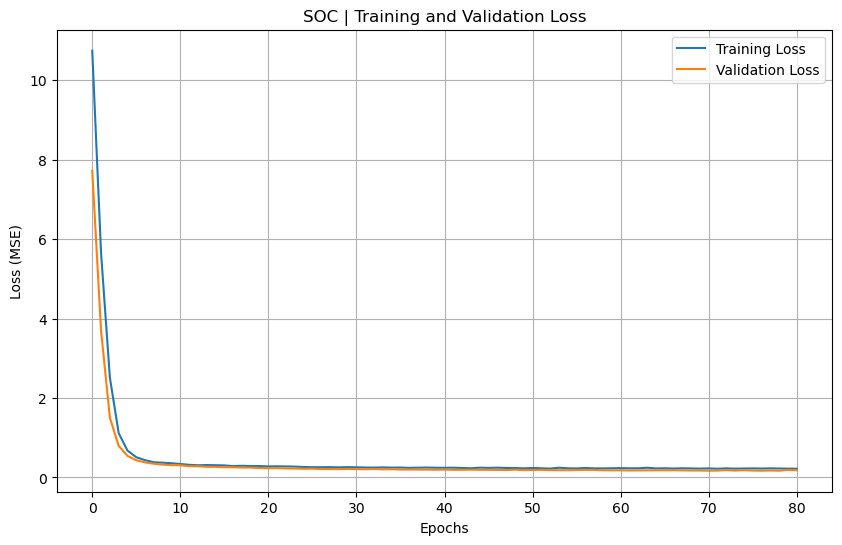

🏃 View run Maz | TF | SOC | L1/L2 Regularization | Run 3 at: https://dagshub.com/Omdena/IPage.mlflow/#/experiments/27/runs/baae8e85626042dbb21c63e88848aa43
🧪 View experiment at: https://dagshub.com/Omdena/IPage.mlflow/#/experiments/27


In [58]:
# ------------------------
# MLflow experiment setup
# ------------------------
# URI_LOCAL = "http://127.0.0.1:5000"
# URI_MAZ = "https://dagshub.com/mm-mazhar/IPAGE.mlflow"
URI_OMDENA = "https://dagshub.com/Omdena/IPage.mlflow"

EXPERIMENT_NAME = f"Maz | TF | {SELECTED_TARGET} | L1/L2 Regularization"
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.set_tracking_uri(URI_OMDENA)

# Train with MLflow tracking
with mlflow.start_run(run_name=f"{EXPERIMENT_NAME} | Run 3"):
    # Log parameters
    mlflow.log_param("input_dim", input_dim)
    mlflow.log_param("early_stopping_patience", PATIENCE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=RESTORE_BEST_WEIGHTS,
        verbose=1
    )

    if APPLY_DYNAMIC_LI_REG:
        print(f"Training with Dynamic L1")
        # Log parameters specific to Dynamic L1
        mlflow.log_param("dynamic_l1_factor", dynamic_l1_factor.numpy())
        mlflow.log_param("update_rate", UPDATE_RATE)
        mlflow.log_param("patience_for_L1", PATIENCE_FOR_L1)
        mlflow.log_param("max_l1_factor", MAX_L1_FACTOR)
        
        # Dynamic L1 callback
        dynamic_callback = FlexibleL1RegularizationCallback(
            l1_factor=dynamic_l1_factor, 
            is_dynamic=True, 
            update_rate=UPDATE_RATE, 
            monitor='val_loss', 
            patience=PATIENCE_FOR_L1, 
            max_l1_factor=MAX_L1_FACTOR
        )

        # Train the model with Dynamic L1 Regularization CallBack
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[dynamic_callback, early_stopping]
        )

        print(f"Dynamic L1 Factor: {dynamic_l1_factor.numpy()}")
        print(f"Update Rate: {UPDATE_RATE}")
        print(f"Max L1 Factor: {MAX_L1_FACTOR}")

    else:
        # Train the model with Static L1 Regularization
        print(f"Training with L1 and L2 Regularization")
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopping]
        )

    # Compute validation predictions for val_r2
    y_val_pred = model.predict(X_val_scaled)
    val_r2 = r2_score(y_val, y_val_pred)

    # Evaluate the model
    test_loss, test_mae, test_mse, test_rmse = model.evaluate(X_test_scaled, y_test, verbose=0)
    y_test_pred = model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)

    # Track the best R² score
    if not hasattr(mlflow, "best_test_r2"):
        mlflow.best_test_r2 = -np.inf  # Initialize if not already set
    
    # Update and log the best R² score
    if test_r2 > mlflow.best_test_r2:
        mlflow.best_test_r2 = test_r2
        mlflow.log_param("best_test_r2", mlflow.best_test_r2)
    
    print(f"Best Test R²: {mlflow.best_test_r2:.4f}")

    # Get overfitting status
    overfitting_status, overfitting_numeric = get_overfitting_status(val_r2, test_r2)

    # Log metrics
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_param("overfitting_status", overfitting_status)
    mlflow.log_param("overfitting_numeric", overfitting_numeric)

    print(f"Test Loss: {test_loss}")
    print(f"Test MAE: {test_mae}")
    print(f"Test MSE: { test_mse}")
    print(f"Test RMSE:{test_rmse}")
     
    print(f"Validation R²: {val_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Overfitting Status: {overfitting_status}")
    
    # Log the model
    mlflow.keras.log_model(model, "model")

    # Plot and log training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'{SELECTED_TARGET} | Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_training_history_r2_{test_r2:.4f}.png")
    plt.show()

    # Log the training history plot as an artifact
    mlflow.log_artifact(f"{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_training_history_r2_{test_r2:.4f}.png")

In [59]:
model.save(f'{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_model_r2_{test_r2:.4f}.h5')

In [60]:
model.save(f'{MODEL_SAVE_PATH}tf_{SELECTED_TARGET}_model_r2_{test_r2:.4f}.keras')